In [99]:
import sys
import math

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 200
plt.style.use(['dark_background'])


In [149]:
# Euler angles to Quaternion (from https://github.com/asarnow/pyem geom.py)
def euler2quat(alpha, beta, gamma):
    ha, hb, hg = alpha / 2, beta / 2, gamma / 2
    ha_p_hg = ha + hg
    hg_m_ha = hg - ha
    q = [np.cos(ha_p_hg) * np.cos(hb),
                  np.sin(hg_m_ha) * np.sin(hb),
                  np.cos(hg_m_ha) * np.sin(hb),
                  np.sin(ha_p_hg) * np.cos(hb)]
    return q

# Quaternion to Euler Angles (from https://github.com/asarnow/pyem geom.py)
def quat2euler(q):
    ha1 = np.arctan2(q[1], q[2])
    ha2 = np.arctan2(q[3], q[0])
    alpha = ha2 - ha1  # np.arctan2(r21/r20)
    beta = 2 * np.arccos(np.sqrt(q[0]**2 + q[3]**2))  # np.arccos*r33
    gamma = ha1 + ha2  # np.arctan2(r12/-r02)
    return alpha, beta, gamma

# Angular distance between two quaternions
def quatDist(a,b):
    # Check to verify that quaternions are unit lengths
    assert abs(math.sqrt(a[0]**2+a[1]**2+a[2]**2+a[3]**2)-1)<.001,"a is not a unit quaternion"
    assert abs(math.sqrt(b[0]**2+b[1]**2+b[2]**2+b[3]**2)-1)<.001,"b is not a unit quaternion"
    
    # Compute distance
    s = a[0]*b[0] + a[1]*b[1] + a[2]*b[2] + a[3]*b[3]
    s = 2*(s**2)-1
    return np.arccos(s)*180/np.pi

def quatMult(a, b):
    w0, x0, y0, z0 = a
    w1, x1, y1, z1 = b
    return [-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0]

def quatInv(a):
    denom = a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2
    return [a[0]/denom, -1*a[1]/denom, -1*a[2]/denom, -1*a[3]/denom]

def quatMag(a):
    return np.sqrt(a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2)

def quat2aa(q):
    theta = 2*np.arccos(q[0])
    x = q[1]/np.sqrt(1-q[0]**2)
    y = q[2]/np.sqrt(1-q[0]**2)
    z = q[3]/np.sqrt(1-q[0]**2)
    return theta, [x,y,z]

In [150]:
def perturbQuat(q1,sigma_angle):
    # pick the angular error distance to apply to this particle
    d = abs(np.random.normal(0, sigma_angle ,1))
    d = sigma_angle
    # the first component dq_0 is given by the following:
    dq0 = np.sqrt((1+np.cos(d*(np.pi/180)))/2)

    # the components dq_1,2,3 are given in terms of two random numbers on [0,1] u_1 and u_2:
    u1 = np.random.uniform(0,1,1)
    u2 = np.random.uniform(0,1,1)

    dq1 = z = 2*u1 - 1
    dq2 = np.sqrt(1-z**2)*np.cos(2*np.pi*u2)
    dq3 = np.sqrt(1-z**2)*np.sin(2*np.pi*u2)

    norm = np.sqrt((1-np.cos(d*(np.pi/180)))/2)

    dq1 = dq1*norm
    dq2 = dq2*norm
    dq3 = dq3*norm

    dq = [dq0, dq1, dq2, dq3]

#     qx = quatMult(quatMult(dq,q1),quatInv(dq))
    return quatMult(dq,q1)
    


<IPython.core.display.Javascript object>


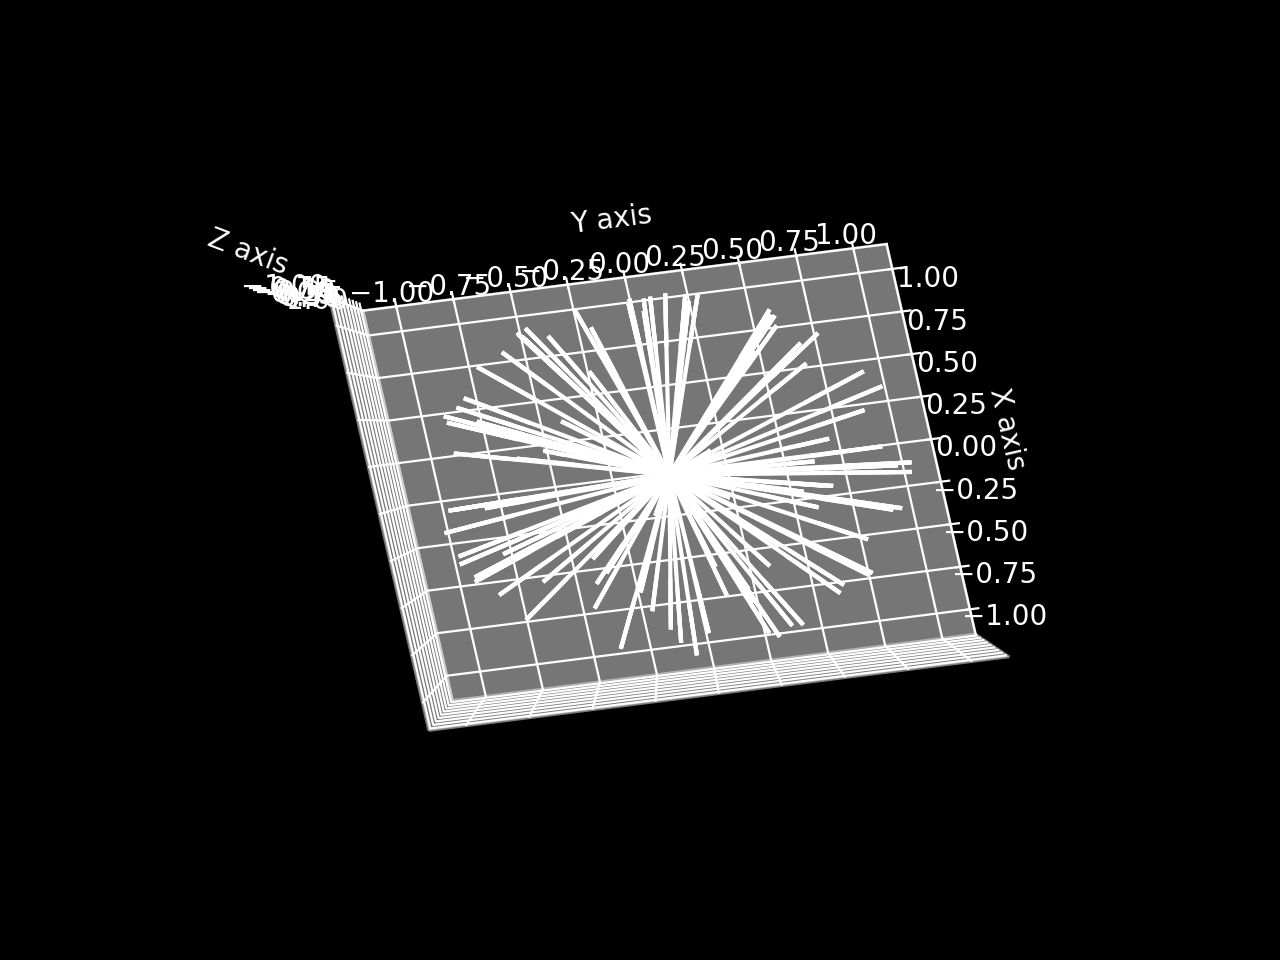

In [196]:
from mpl_toolkits import mplot3d
%matplotlib notebook

# Initial Euler angles (example)
psi = 90 *(np.pi/180)
rot = 10 *(np.pi/180)
tilt = 0 *(np.pi/180)
# calculate the quaternion of the theoretical orientation from the euler angles
q1 = euler2quat(psi, rot, tilt)


qxs = []
for i in range(100):
    qx = perturbQuat(q1,180)
    qxs.append(quat2aa(qx)[1])
#     print(quatDist(q1,qx))

v = qxs

X = [float(i[0]) for i in v]
Y = [float(i[1]) for i in v]
Z = [float(i[2]) for i in v]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.quiver(X,Y,Z,X,Y,Z,length=1,pivot='tip')
ax.quiver(quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],length=1.5,pivot='tip',color='r')




In [152]:
v

[(array([2.17110109]),
  [-0.24189312427103182, -0.09799140472363935, -0.9653421160555916]),
 (array([4.51472811]),
  [-0.6973731309471561, -0.38064303394838434, -0.607273906025551]),
 (array([3.67875513]),
  [-0.7624472059050366, -0.31658080553012397, -0.5643144972242876]),
 (array([3.71609579]),
  [-0.23817508704980198, 0.7462991801803383, -0.6215385439141922]),
 (array([4.12843859]),
  [-0.7590420142936869, 0.3720420520600261, -0.5342657878209565]),
 (array([3.29589289]),
  [-0.014487622827775106, -0.6596798736206111, -0.7514070622004393]),
 (array([3.50551459]),
  [-0.802317329726815, 0.2354929074027558, -0.5484797106393547]),
 (array([4.12399238]),
  [0.42586805759649465, 0.5032537577318381, -0.7519122640626187]),
 (array([2.34929093]),
  [-0.10067654288875034, -0.3447112248605942, -0.9332943829077073]),
 (array([2.83287739]),
  [0.22392884204692523, 0.5114549093894407, -0.8296202440640911]),
 (array([2.45267508]),
  [-0.6092711792071009, -0.03501799060367539, -0.7921883428337415]

array([-0.21644636])